## San Francisco Crime Classification


### 머신러닝 알고리즘을 활용하여 샌프란시스코에서 발생한 범죄의 종류를 예측하기

In [220]:
import pandas as pd

In [221]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


## 탐험적 데이터 분석(EDA)

In [222]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Dates

```Dates``` 컬럼에서는 범죄가 어느 날짜/시간에 발생했는지 연월일시분초로 표현되어 있음. 이 컬럼을 활용해서, 범죄가 특정 연도, 월, 일, 시간, 분, 초에 많이 발생하는지 적게 발생하는지를 알 수 있다.

In [223]:
train["Dates"] = pd.to_datetime(train["Dates"])
train["Dates-year"] = train["Dates"].dt.year
train["Dates-month"] = train["Dates"].dt.month
train["Dates-day"] = train["Dates"].dt.day
train["Dates-hour"] = train["Dates"].dt.hour
train["Dates-minute"] = train["Dates"].dt.minute
train["Dates-second"] = train["Dates"].dt.second

print(train.shape)
train[["Dates", "Dates-year", "Dates-month", "Dates-day", "Dates-hour", "Dates-minute", "Dates-second"]].head()

(878049, 15)


,Dates,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
0,2015-05-13 23:53:00,2015,5,13,23,53,0
1,2015-05-13 23:53:00,2015,5,13,23,53,0
2,2015-05-13 23:33:00,2015,5,13,23,33,0
3,2015-05-13 23:30:00,2015,5,13,23,30,0
4,2015-05-13 23:30:00,2015,5,13,23,30,0


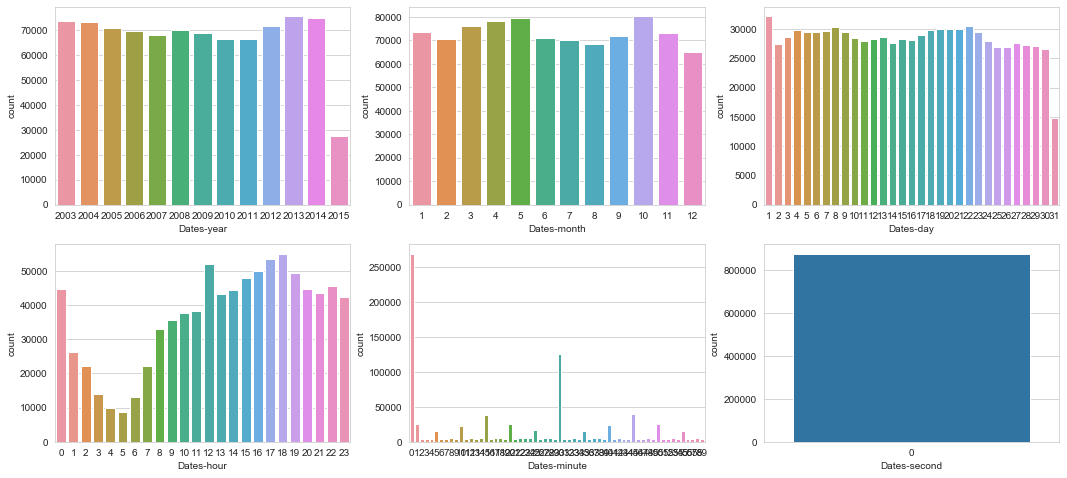

In [224]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)

figure.set_size_inches(18, 8)

# 연, 월, 일, 시, 분, 초 별 범죄의 발생 빈도를 출력
sns.countplot(data=train, x="Dates-year", ax=ax1)
sns.countplot(data=train, x="Dates-month", ax=ax2)
sns.countplot(data=train, x="Dates-day", ax=ax3)
sns.countplot(data=train, x="Dates-hour", ax=ax4)
sns.countplot(data=train, x="Dates-minute", ax=ax5)
sns.countplot(data=train, x="Dates-second", ax=ax6)

이 시각화로 발견할 수 있는 사실

일(```Dates-day```) 31일을 제외하면 범죄의 발생 빈도를 판가름하는데 별 영향이 없을 것 같다.:

31일은 확실히 다른 날에 비해서 범죄가 절반 정도밖에 발생하지 않는다. 하지만 여기서도 특이한 사실을 알 수 있는데, 1일의 범죄 발생 빈도가 다른 날에 비해서 비약적으로 높다. 

시간(```Dates-hour```)은 범죄 발생 빈도에 큰 영향이 있을 것 같다.:

확실히 새벽에 범죄가 덜 발생하는 것 같고, 오후와 저녁에 범죄가 많이 발생하는 것 같습니다. 하지만 여기서도 신기한 사실은, 특이하게 0시와 12시에 범죄가 발생하는 빈도가 높은 것 같습니다. 

예측모델 개선 방안)
1. 일단 초(```Dates-second```)는 전부 다 0으로 기록되어 있기 때문에, 범죄를 예측하는데 크게 중요하지 않을 것 같습니다. 그러므로 feature에서 제거하는 것도 좋은 아이디어 같습니다.
2. 다른 컬럼들, 특히나 시간(```Dates-hour```) 데이터는 예측 모델이 범죄를 예측하는데 큰 영향을 미칠 것 같습니다.
3. 분(```Dates-minute```)과 같은 기록이 잘 정리되지 않은 데이터는 잘 정리해서 머신러닝 모델에 집어넣으면 모델이 이 데이터를 이해하는데 도움이 될 것이다.

## 좌표 데이터

 데이터에서는 ```Y``` 컬럼이 위도를, ```X``` 컬럼이 경도를 나타냅니다. 이 정보는 범죄가 구체적으로 어떤 위치에서 발생했는지를 좌표로 찍어준거라고 볼 수 있습니다.

이런 좌표 정보를 시각화를 통해서 분석할 수 있는 가장 일반적인 방법은 seaborn의 [lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html)

1. 일단 샌프란시스코의 좌표 데이터이기 때문에, 샌프란시스코의 지도와 유사한 그림이 나올 것으로 생각합니다.
2. 하지만 현실세계의 데이터이기 때문에, 샌프란시스코 지도 외각으로 데이터의 분포와 동떨어진 아웃라이어(outlier)가 존재할 것 같습니다.
3. 그리고 범죄의 종류(ex: 절도, 살인 등)와 관계 없이 범죄 자체가 아에 발생할 가능성이 낮은 지역에는 그림에서 공백으로 보일 것 같습니다.

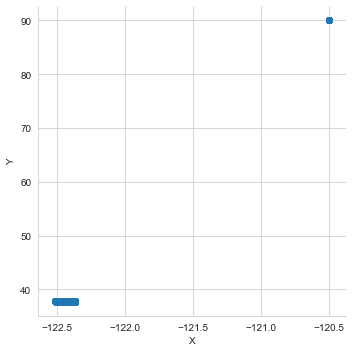

In [225]:
# seaborn의 lmplot을 사용해 좌표 데이터를 출력합니다.
# X축에는 경도(Longitude)를 나타내는 X를, Y축에는 위도(Latitude)를 나타내는 Y를 지정합니다.
# 추세선을 그리지 않기 위해(계산하는데 너무 느려서) fit_reg 옵션에 False를 주겠습니다.
sns.lmplot(data=train, x="X", y="Y", fit_reg=False)

## 아웃라이어 제거

In [226]:
# 경도(Longitude, X)와 위도(Latitude, Y)에서 가장 높은 값을 검색, 이 점에 위치한 데이터가 아웃라이어(outlier)일 것으로 예상.
train["X"].max(), train["Y"].max()

(-120.5, 90.0)

In [227]:
X_outliers = (train["X"] == train["X"].max())
Y_outliers = (train["Y"] == train["Y"].max())
outlier = train[X_outliers & Y_outliers]
print(outlier.shape)
outlier

(67, 15)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005,12,30,17,0,0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,34,0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,34,0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0,2005,12,29,0,7,0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0,2005,11,30,11,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,2003,6,11,8,49,0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,2003,6,9,9,25,0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0,2003,5,2,1,0,0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0,2003,4,14,16,30,0


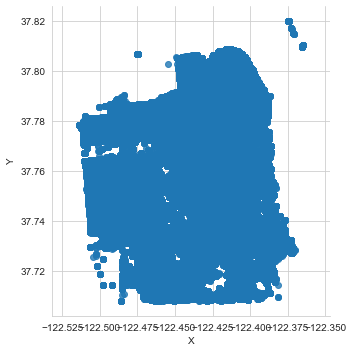

In [228]:
# 아웃라이어 제거 후 시각화
non_outliers = train[~(X_outliers & Y_outliers)]
sns.lmplot(data=non_outliers, x="X", y="Y", fit_reg=False)

1. 아웃라이어가 전체 데이터의 0.01%도 되지 않기 때문에, 이 아웃라이어를 해결한다고 모델의 성능이 크게 좋아지지는 않을 것입니다.
2. 아직 범죄 종류(ex: 절도, 살인 등)마다의 좌표 데이터의 변화를 보지 못했지만, 만일 범죄 종류마다 좌표 데이터가 차이가 있다면(=특정 지역에서 많이 발생하는 범죄 등이 있다면) 이 데이터를 머신러닝 모델에 집어 넣으면 성능을 좋게 만들 수 있을 것 같다.
3. 아웃라이어가 존재한다면, 이를 정상적인 값으로 고치거나, 아예 아웃라이어를 배제하면 머신러닝 알고리즘이 아웃라이어에로 인해서 성능이 낮아지는 현상이 사라질 것 같다.

## DayOfWeek


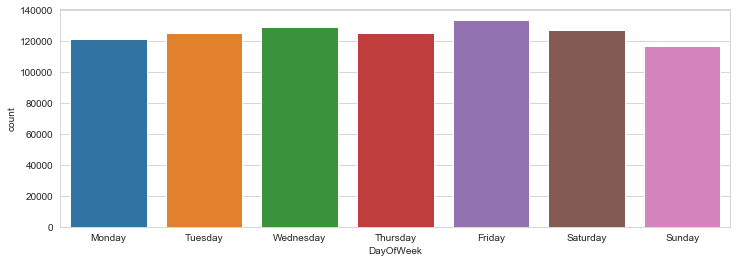

In [229]:
plt.figure(figsize = (12, 4))

dayofweek_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.countplot(data = train, x = "DayOfWeek", order = dayofweek_list)

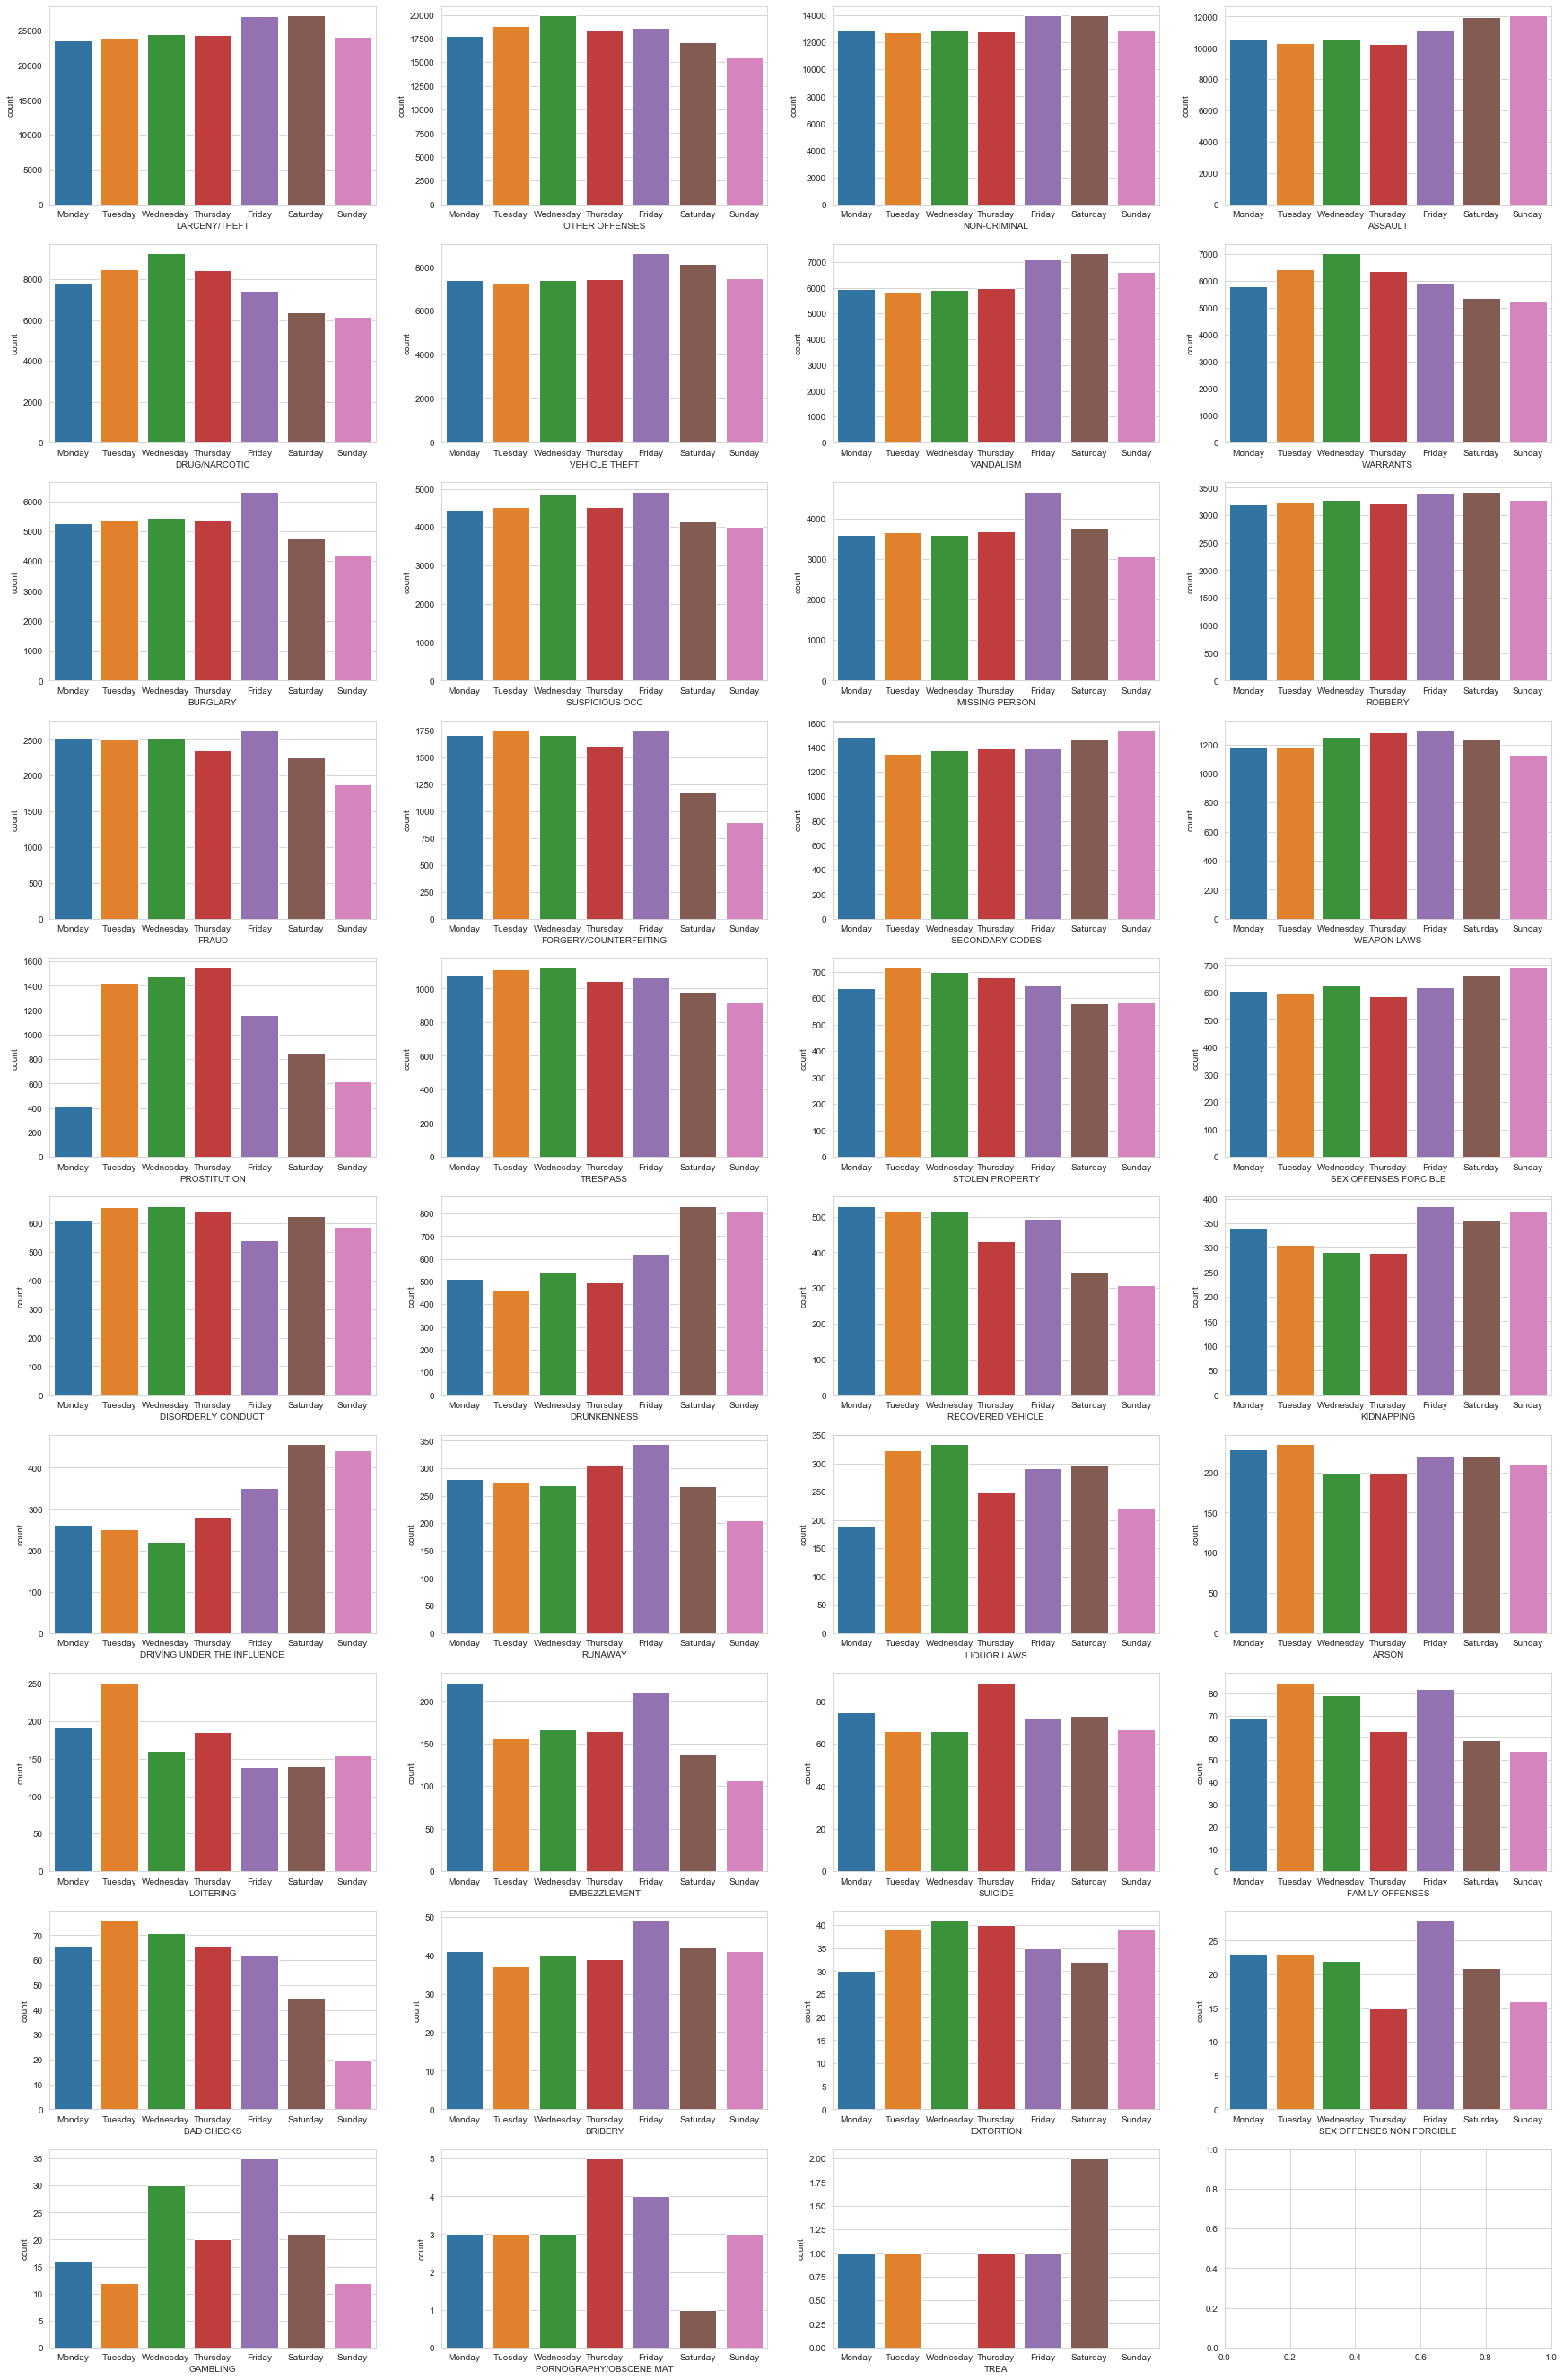

In [230]:
figure, axes = plt.subplots(nrows = 10, ncols = 4)
figure.set_size_inches(30, 48)

category_list = train["Category"].value_counts().index

for row in range(10):
    for column in range(4):
        index = row * 4 + column
        
        if index < len(category_list):
            ax = axes[row][column]
            category = category_list[index]
        
            target = train[train["Category"] == category]
            sns.countplot(data = target, x = "DayOfWeek", order = dayofweek_list, ax = ax)

            ax.set(xlabel = category)

몇몇 특정 범죄에 한해서 주중일때와 주말일때 차이가 많이 날 것 같다. 가령 주말일 경우에 많이 발생하는 범죄가 있을 것 같다.**
  * 시각화 결과 과음(DRUNKENNESS), 음주운전(DRIVING UNDER THE INFLUENCE) 같은 경우가 주말에 많이 발생한다.

주말일 경우에는 덜 발생하는 범죄도 존재할 것이다.**
  * 마약(DRUG/NARCOTIC), 절도(BURGLARY) 등이 그에 해당한다 위조(FORGERY/COUNTERFEITING)

주말은 금토 or 토일이 될 것 같다.
  * 절도(LARCENY/THEFT)의 경우에는 금,토에 많이 발생한다.

**요일(```DayOfWeek```)이 범죄를 판가름하는데 중요한 영향을 끼친다는 것을 알 수 있다.** 

## PdDistrict


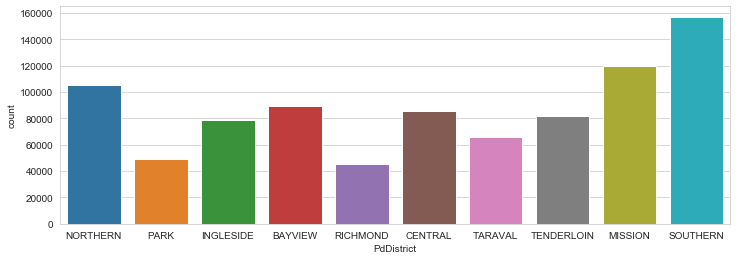

In [231]:
plt.figure(figsize = (12, 4))

sns.countplot(data = train, x = "PdDistrict")

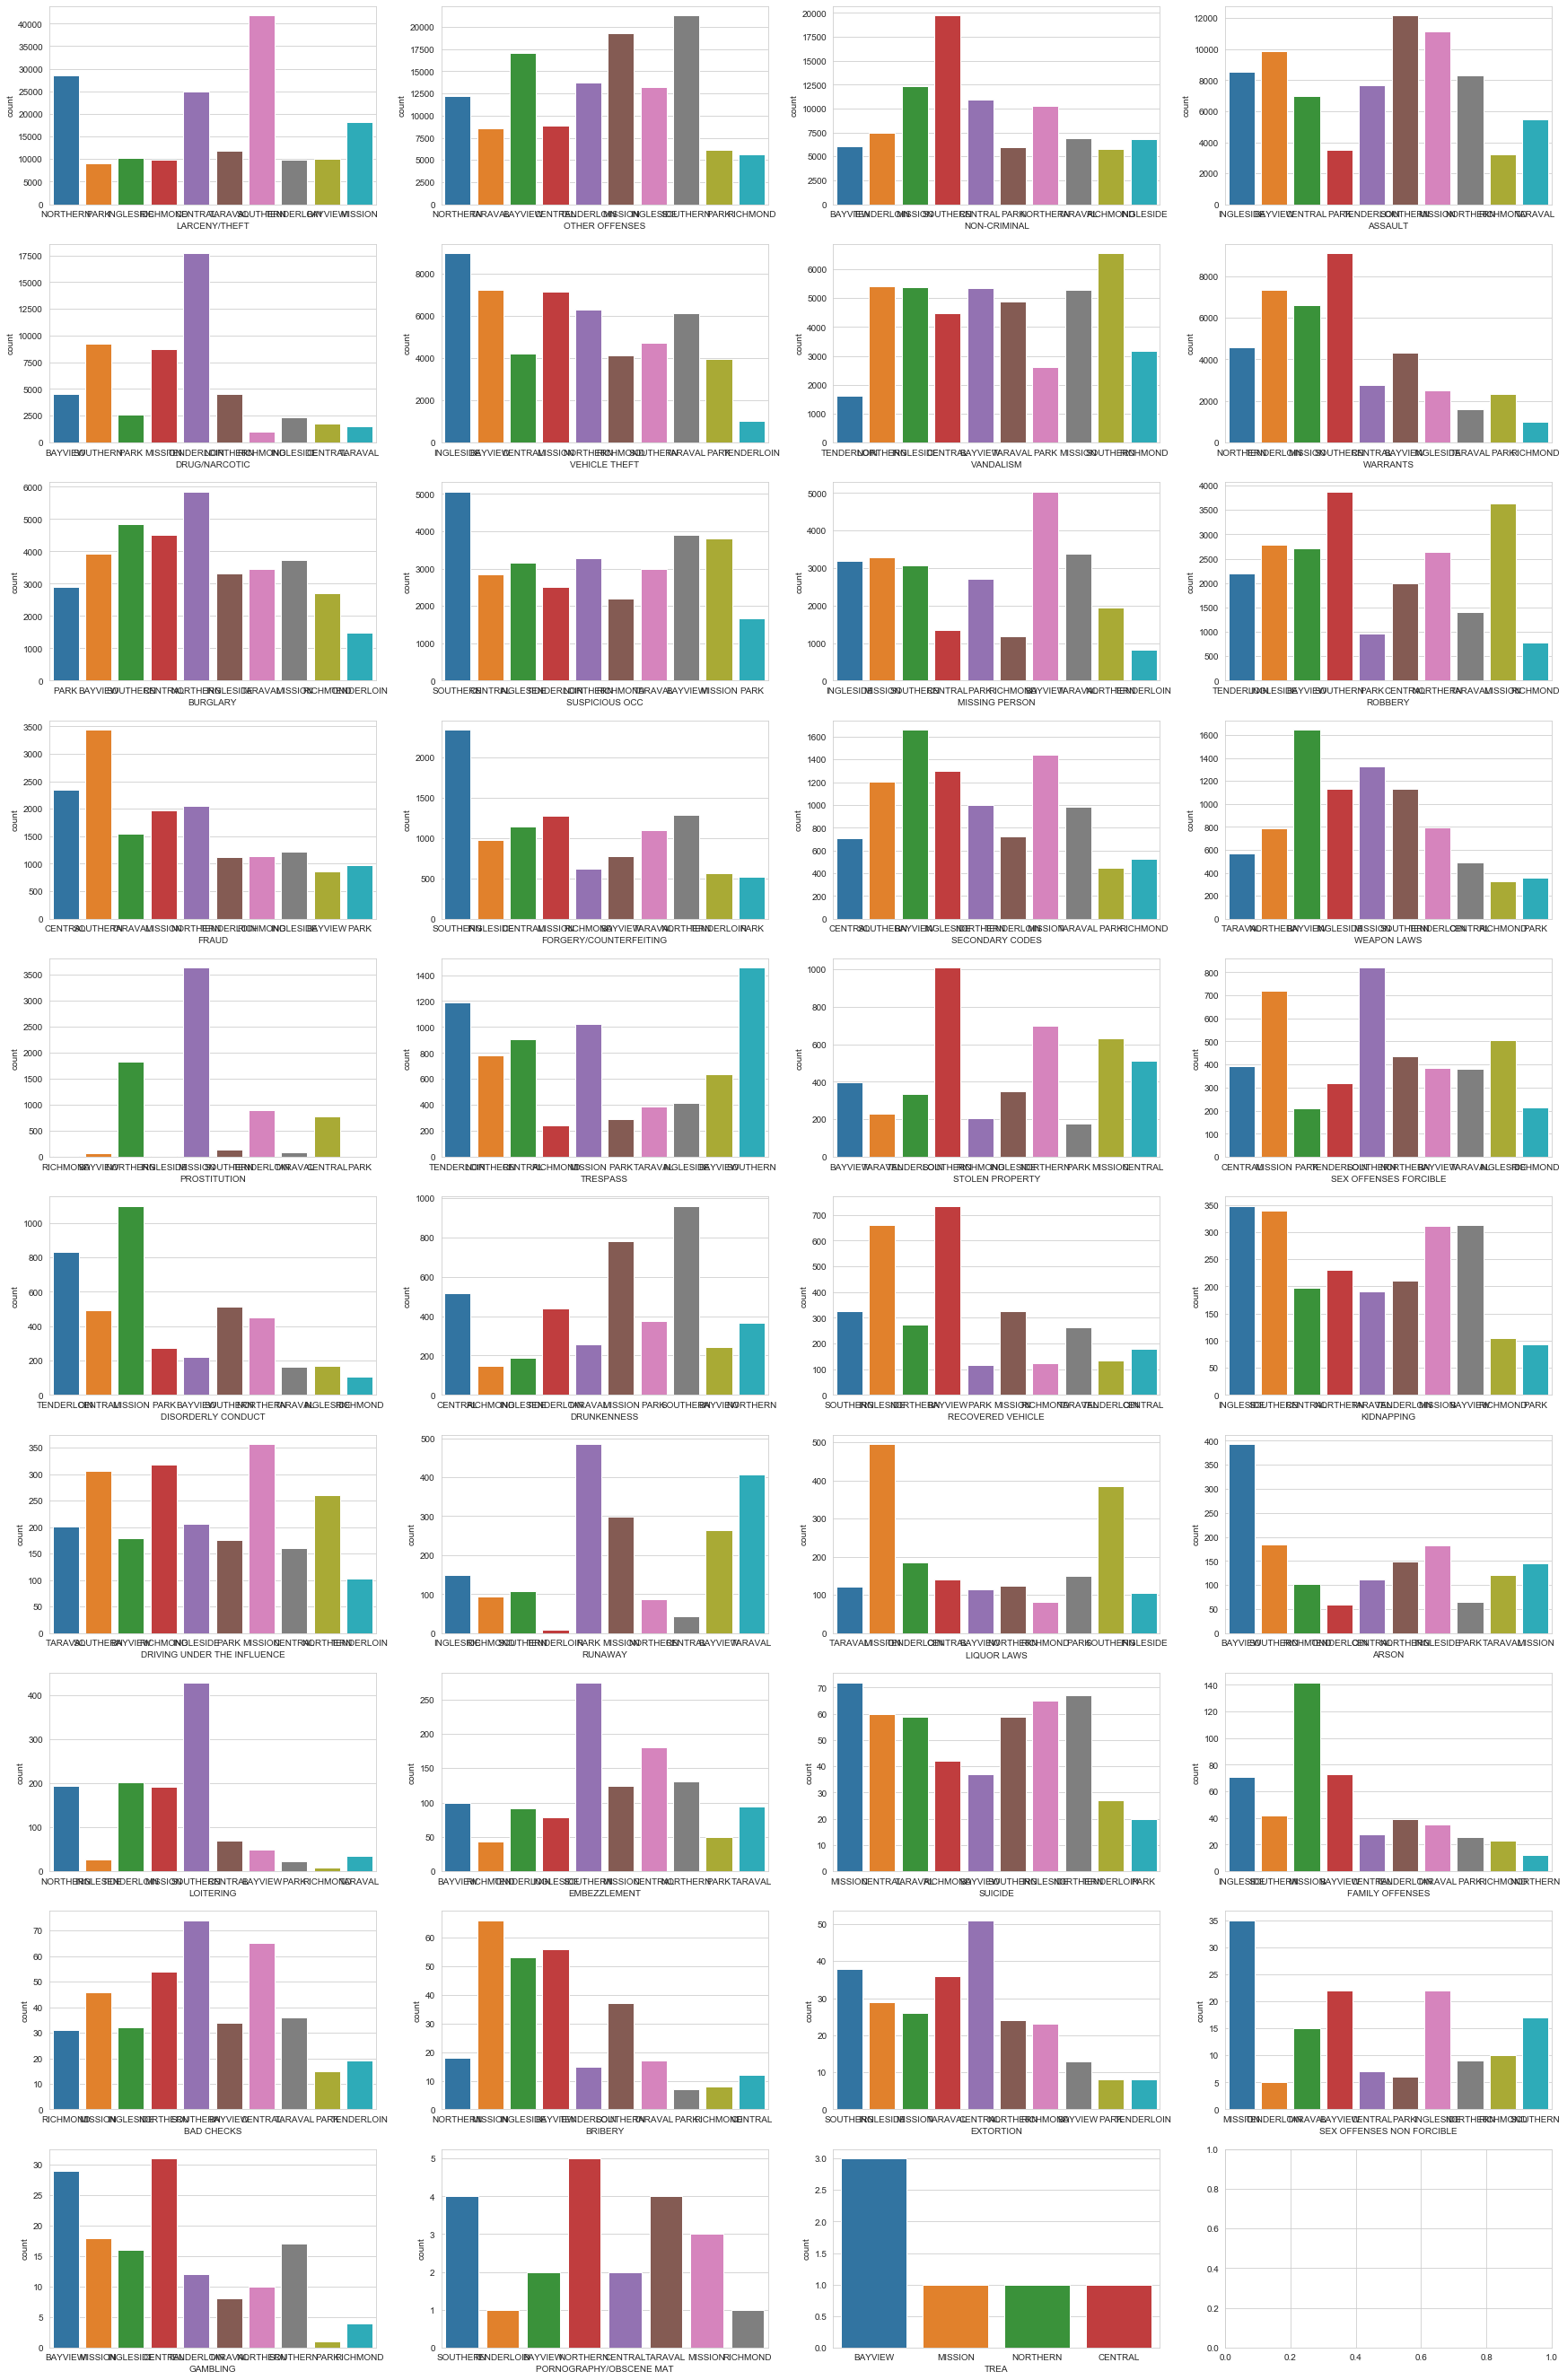

In [232]:
figure, axes = plt.subplots(nrows = 10, ncols = 4)
figure.set_size_inches(30, 48)

category_list = train["Category"].value_counts().index

for row in range(10):
    for column in range(4):
        index = row * 4 + column
        
        if index < len(category_list):
            ax = axes[row][column]
            category = category_list[index]
        
            target = train[train["Category"] == category]
            sns.countplot(data = target, x = "PdDistrict", ax = ax)

            ax.set(xlabel = category)

1. 관할 경찰서가 곧 지역을 상징하므로, 범죄가 많이 발생하는 지역에 범죄 발생 빈도가 몰릴 것 같다.
  * SOUTHERN의 경우에는 범죄가 타 지역에 비해서 굉장히 많이 발생하는 편이다.
  * 정 반대로 PARK와 RICHMOND는 범죄 발생 빈도가 낮은 편이다.
2. 그리고 범죄의 타입에 따라, 특정 상황에 자주 발생하는 범죄가 있을 것이다.
  * 맞다. 가령 TARAVAL의 경우 절도(LARCENY/THEFT)가 굉장히 많이 발생하고, 마약(DRUG/NARCOTIC)의 경우에는 RICHMOND에서 매우 자주 발생한다.


**관할 경찰서마다 범죄 발생 횟수가 이 정도로 명확한 데이터라면, 단순히 데이터를 [One Hot Encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) 해서 넣어줘도 큰 효과를 발휘할 것 같다. 또한 관할 경찰서라고 하더라도 결국에는 지역 데이터를 상징한다. 그러므로 다른 지역 데이터인 주소(Address), 좌표(X, Y)와 엮어줄 수 있는 방법이 있다면 모델의 성능을 개선하는데 더 큰 도움이 될 것.


## Address


In [233]:
train["Crossroad"] = train["Address"].str.contains("/")

print(train.shape)
train[["Address", "Crossroad"]].head()

(878049, 16)


,Address,Crossroad
0,OAK ST / LAGUNA ST,True
1,OAK ST / LAGUNA ST,True
2,VANNESS AV / GREENWICH ST,True
3,1500 Block of LOMBARD ST,False
4,100 Block of BRODERICK ST,False


### Address 컬럼 시각화하기

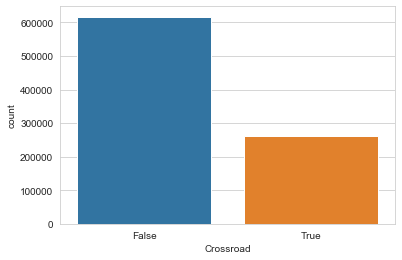

In [234]:
sns.countplot(data=train, x="Crossroad")

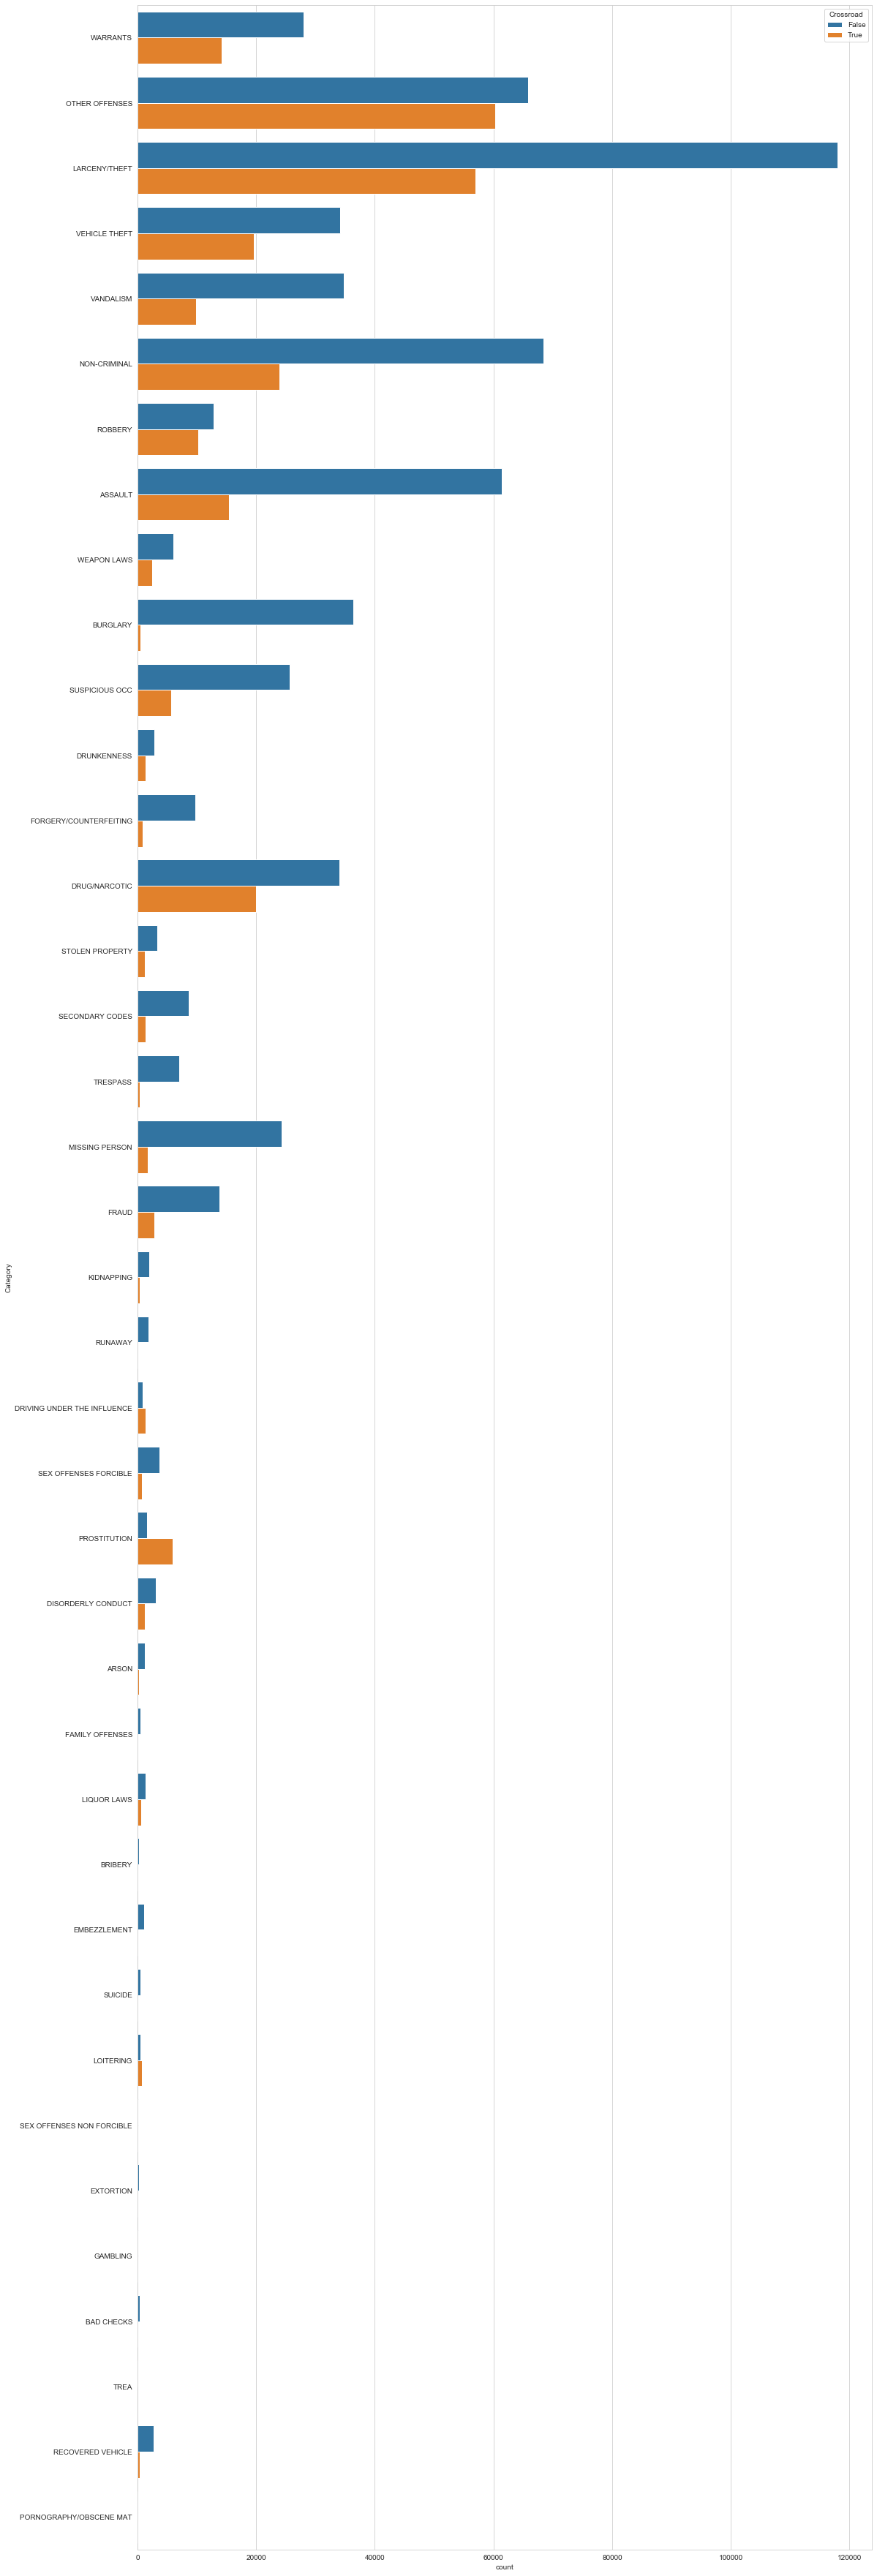

In [235]:
plt.figure(figsize = (18, 64))

sns.countplot(data=train, hue="Crossroad", y="Category")

In [236]:
train.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second,Crossroad
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0,True
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0,True
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33,0,True


In [237]:
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [238]:
train['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [239]:
len(train['Descript'].unique().tolist())

879

In [240]:
white_crime=["FRAUD", "FORGERY/COUNTERFEITING", "BAD CHECKS" , "EXTORTION", "EMBEZZLEMENT", "SUSPICIOUS OCC",
              "BRIBERY"]

blue_crime=["VANDALISM", "LARCENY/THEFT", "STOLEN PROPERTY", "ROBBERY", "DRIVING UNDER THE INFLUENCE",
             "DISORDERLY CONDUCT", "LIQUOR LAWS", "VEHICLE THEFT", "ASSAULT", "KIDNAPPING", "TRESPASS", 
             "ARSON", "RECOVERED VEHICLE"]
             
other_crime=["MISSING PERSON", "RUNAWAY", "FAMILY OFFENSES", "SEX OFFENSES NON FORCIBLE",
             "PORNOGRAPHY/OBSCENE MAT", "WEAPON LAWS", "DRUNKENNESS", "SUICIDE", "TREA",
             "DRUG/NARCOTIC", "SEX OFFENSES FORCIBLE",  "LOITERING"]


In [241]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second,Crossroad
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0,True
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0,True
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33,0,True
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30,0,False
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30,0,False


In [242]:
test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,...,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Crossroad,Dates-minute(abs),800BRYANT,800MARKET,2000MISSION,1000POTRERO,900MARKET,Block
Id,,,,,,,,,,,,,,,,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23,...,0,0,False,29,False,False,False,False,False,True
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23,...,0,0,True,21,False,False,False,False,False,False
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23,...,0,0,False,20,False,False,False,False,False,True
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,...,0,0,False,15,False,False,False,False,False,True
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,...,0,0,False,15,False,False,False,False,False,True


In [243]:
def find_white_crime(Category) :
    
    for crime in white_crime :

        if crime in Category :
            return True
        else : 
            return False
        

train['white_crime'] = train['Category'].apply(find_white_crime)


In [244]:
def find_blue_crime(Category) :
    
    for crime in blue_crime :

        if crime in Category :
            return True
        else : 
            return False
        

train['blue_crime'] = train['Category'].apply(find_blue_crime)


In [245]:
def find_other_crime(Category) :
    
    for crime in other_crime :

        if crime in Category :
            return True
        else : 
            return False
        

train['other_crime'] = train['Category'].apply(find_other_crime)


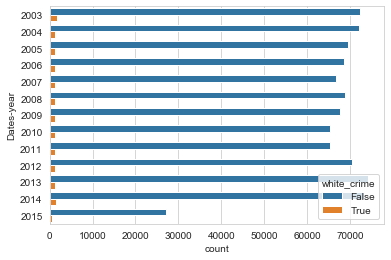

In [246]:
sns.countplot(data=train, hue="white_crime", y="Dates-year")

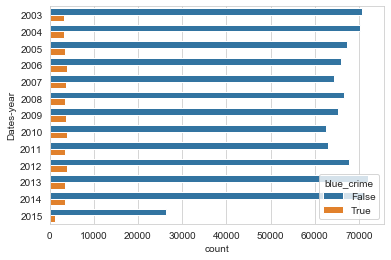

In [247]:
sns.countplot(data=train, hue="blue_crime", y="Dates-year")

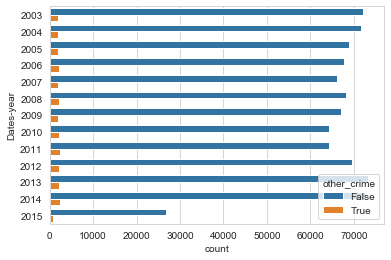

In [248]:
sns.countplot(data=train, hue="other_crime", y="Dates-year")

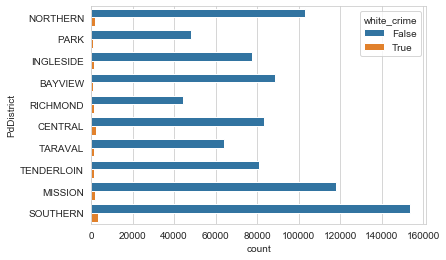

In [249]:
sns.countplot(data=train, hue="white_crime", y="PdDistrict")


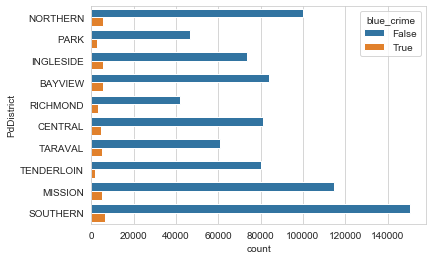

In [250]:
sns.countplot(data=train, hue="blue_crime", y="PdDistrict")


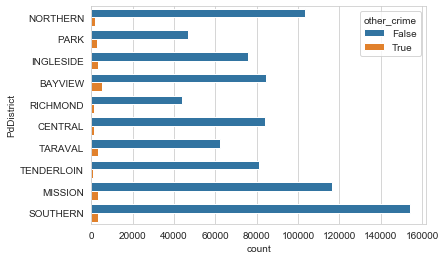

In [251]:
sns.countplot(data=train, hue="other_crime", y="PdDistrict")


### Reload Dataset

탐험적 데이터 분석(EDA)을 끝나면, 분석이 끝난 데이터를 머신러닝 알고리즘을 활용하여 예측

In [252]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [253]:
test = pd.read_csv("test.csv", index_col = "Id")
print(test.shape)
test.head()

(884262, 6)


,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


## Preprocessing
\
데이터를 머신러닝 알고리즘에 넣기 위해서는 데이터를 머신러닝 알고리즘이 이해할 수 있는 형태로 변환해줘야 함 (전처리(Preprocessing)


[scikit-learn] 기준

  * 모든 데이터는 숫자(정수형, 실수형 등)로 구성되어 있어야 한다.
  * 데이터에 빈 값이 없어야 한다.


In [254]:
train["Dates"] = pd.to_datetime(train["Dates"])
train["Dates-year"] = train["Dates"].dt.year
train["Dates-month"] = train["Dates"].dt.month
train["Dates-day"] = train["Dates"].dt.day
train["Dates-hour"] = train["Dates"].dt.hour
train["Dates-minute"] = train["Dates"].dt.minute
train["Dates-second"] = train["Dates"].dt.second
print(train.shape)
train[["Dates", "Dates-year", "Dates-month", "Dates-day", "Dates-hour", "Dates-minute", "Dates-second"]].head()

(878049, 15)


,Dates,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
0,2015-05-13 23:53:00,2015,5,13,23,53,0
1,2015-05-13 23:53:00,2015,5,13,23,53,0
2,2015-05-13 23:33:00,2015,5,13,23,33,0
3,2015-05-13 23:30:00,2015,5,13,23,30,0
4,2015-05-13 23:30:00,2015,5,13,23,30,0


In [255]:
test["Dates"] = pd.to_datetime(test["Dates"])
test["Dates-year"] = test["Dates"].dt.year
test["Dates-month"] = test["Dates"].dt.month
test["Dates-day"] = test["Dates"].dt.day
test["Dates-hour"] = test["Dates"].dt.hour
test["Dates-minute"] = test["Dates"].dt.minute
test["Dates-second"] = test["Dates"].dt.second
print(test.shape)
test[["Dates", "Dates-year", "Dates-month", "Dates-day", "Dates-hour", "Dates-minute", "Dates-second"]].head()

(884262, 12)


,Dates,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second
Id,,,,,,,
0,2015-05-10 23:59:00,2015,5,10,23,59,0
1,2015-05-10 23:51:00,2015,5,10,23,51,0
2,2015-05-10 23:50:00,2015,5,10,23,50,0
3,2015-05-10 23:45:00,2015,5,10,23,45,0
4,2015-05-10 23:45:00,2015,5,10,23,45,0


In [256]:
train_dayofweek = pd.get_dummies(train["DayOfWeek"], prefix = "DayOfWeek")

# concat == concatenate
train = pd.concat([train, train_dayofweek], axis = 1)

print(train.shape)
train.head()

(878049, 22)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,...,Dates-hour,Dates-minute,Dates-second,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,23,53,0,0,0,0,0,0,0,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,23,53,0,0,0,0,0,0,0,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,23,33,0,0,0,0,0,0,0,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,23,30,0,0,0,0,0,0,0,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,23,30,0,0,0,0,0,0,0,1


In [257]:
test_dayofweek = pd.get_dummies(test["DayOfWeek"], prefix = "DayOfWeek")

# concat == concatenate
test = pd.concat([test, test_dayofweek], axis = 1)

print(test.shape)
test.head()

(884262, 19)


,Dates,DayOfWeek,PdDistrict,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,Dates-minute,Dates-second,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
Id,,,,,,,,,,,,,,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23,59,0,0,0,0,1,0,0,0
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23,51,0,0,0,0,1,0,0,0
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23,50,0,0,0,0,1,0,0,0
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,45,0,0,0,0,1,0,0,0
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,45,0,0,0,0,1,0,0,0


In [258]:
train_pddistrict = pd.get_dummies(train["PdDistrict"], prefix = "PdDistrict")

# concat == concatenate
train = pd.concat([train, train_pddistrict], axis = 1)

print(train.shape)
train.head()

(878049, 32)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0,0,0,0,1,0,0,0,0,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0,0,0,0,1,0,0,0,0,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,0,0,0,0,1,0,0,0,0,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,0,0,0,0,1,0,0,0,0,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,0,0,0,0,0,1,0,0,0,0


In [259]:
test_pddistrict = pd.get_dummies(test["PdDistrict"], prefix = "PdDistrict")

# concat == concatenate
test = pd.concat([test, test_pddistrict], axis = 1)

print(test.shape)
test.head()

(884262, 29)


,Dates,DayOfWeek,PdDistrict,Address,X,Y,Dates-year,Dates-month,Dates-day,Dates-hour,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
Id,,,,,,,,,,,,,,,,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23,...,1,0,0,0,0,0,0,0,0,0
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23,...,1,0,0,0,0,0,0,0,0,0
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23,...,0,0,0,0,1,0,0,0,0,0
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,...,0,0,1,0,0,0,0,0,0,0
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,...,0,0,1,0,0,0,0,0,0,0


In [260]:
train["Crossroad"] = train["Address"].str.contains("/")

print(train.shape)
train[["Address", "Crossroad"]].head()

(878049, 33)


,Address,Crossroad
0,OAK ST / LAGUNA ST,True
1,OAK ST / LAGUNA ST,True
2,VANNESS AV / GREENWICH ST,True
3,1500 Block of LOMBARD ST,False
4,100 Block of BRODERICK ST,False


In [261]:
test["Crossroad"] = test["Address"].str.contains("/")

print(test.shape)
test[["Address", "Crossroad"]].head()

(884262, 30)


,Address,Crossroad
Id,,
0,2000 Block of THOMAS AV,False
1,3RD ST / REVERE AV,True
2,2000 Block of GOUGH ST,False
3,4700 Block of MISSION ST,False
4,4700 Block of MISSION ST,False


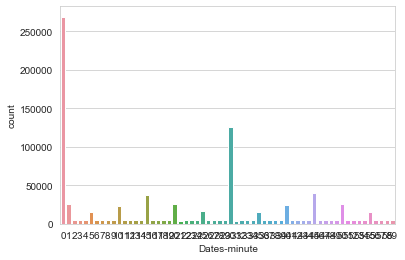

In [262]:
sns.countplot(data = train, x = "Dates-minute")

In [263]:
import numpy as np

train["Dates-minute(abs)"] = np.abs(train["Dates-minute"] - 30)
test["Dates-minute(abs)"] = np.abs(test["Dates-minute"] - 30)

print(train.shape)
train[["Dates-minute", "Dates-minute(abs)"]].head()

(878049, 34)


,Dates-minute,Dates-minute(abs)
0,53,23
1,53,23
2,33,3
3,30,0
4,30,0


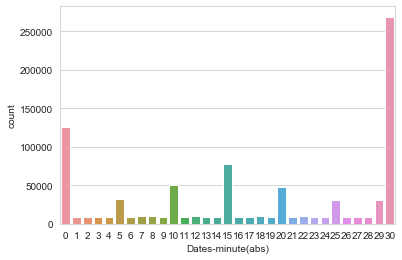

In [264]:
sns.countplot(data = train, x = "Dates-minute(abs)")

In [265]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-year,...,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Crossroad,Dates-minute(abs)
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0,0,1,0,0,0,0,0,True,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0,0,1,0,0,0,0,0,True,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,0,0,1,0,0,0,0,0,True,3
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,0,0,1,0,0,0,0,0,False,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,0,0,0,1,0,0,0,0,False,0


In [266]:
train["Address"].value_counts().index

Index(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '2000 Block of MISSION ST', '1000 Block of POTRERO AV',
       '900 Block of MARKET ST', '0 Block of TURK ST', '0 Block of 6TH ST',
       '300 Block of ELLIS ST', '400 Block of ELLIS ST',
       '16TH ST / MISSION ST',
       ...
       'ROLPH ST / MORSE ST', 'CHENERY ST / CHARLES ST',
       '26TH AV / ELCAMINODELMAR ST', '200 Block of JESSIE ST',
       'DETROIT ST / FLOOD AV', 'MOUNT VERNON AV / GETZ ST',
       '3500 Block of FOLSOM ST', 'CLEMENT ST / 41ST AV',
       'JOICE ST / CALIFORNIA ST', '300 Block of PARK PRESIDIO BL'],
      dtype='object', length=23228)

In [267]:
train["Address"].value_counts()

800 Block of BRYANT ST           26533
800 Block of MARKET ST            6581
2000 Block of MISSION ST          5097
1000 Block of POTRERO AV          4063
900 Block of MARKET ST            3251
                                 ...  
MOUNT VERNON AV / GETZ ST            1
3500 Block of FOLSOM ST              1
CLEMENT ST / 41ST AV                 1
JOICE ST / CALIFORNIA ST             1
300 Block of PARK PRESIDIO BL        1
Name: Address, Length: 23228, dtype: int64

In [268]:
train["Address"].value_counts().index[:10]

Index(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '2000 Block of MISSION ST', '1000 Block of POTRERO AV',
       '900 Block of MARKET ST', '0 Block of TURK ST', '0 Block of 6TH ST',
       '300 Block of ELLIS ST', '400 Block of ELLIS ST',
       '16TH ST / MISSION ST'],
      dtype='object')

In [269]:
train["800BRYANT"] = train["Address"].str.contains("800 Block of BRYANT ST")
train["800MARKET"] = train["Address"].str.contains("800 Block of MARKET ST")
train["2000MISSION"] = train["Address"].str.contains("2000 Block of MISSION ST")
train["1000POTRERO"] = train["Address"].str.contains("1000POTRERO")
train["900MARKET"] = train["Address"].str.contains("900 Block of MARKET ST")


print(train.shape)
train[["Address", "800BRYANT", '800MARKET', '2000MISSION', '1000POTRERO', '900MARKET']].head()

(878049, 39)


,Address,800BRYANT,800MARKET,2000MISSION,1000POTRERO,900MARKET
0,OAK ST / LAGUNA ST,False,False,False,False,False
1,OAK ST / LAGUNA ST,False,False,False,False,False
2,VANNESS AV / GREENWICH ST,False,False,False,False,False
3,1500 Block of LOMBARD ST,False,False,False,False,False
4,100 Block of BRODERICK ST,False,False,False,False,False


In [270]:
test["800BRYANT"] = test["Address"].str.contains("800 Block of BRYANT ST")
test["800MARKET"] = test["Address"].str.contains("800 Block of MARKET ST")
test["2000MISSION"] = test["Address"].str.contains("2000 Block of MISSION ST")
test["1000POTRERO"] = test["Address"].str.contains("1000POTRERO")
test["900MARKET"] = test["Address"].str.contains("900 Block of MARKET ST")


print(test.shape)
test[["Address", "800BRYANT", '800MARKET', '2000MISSION', '1000POTRERO', '900MARKET']].head()

(884262, 36)


,Address,800BRYANT,800MARKET,2000MISSION,1000POTRERO,900MARKET
Id,,,,,,
0,2000 Block of THOMAS AV,False,False,False,False,False
1,3RD ST / REVERE AV,False,False,False,False,False
2,2000 Block of GOUGH ST,False,False,False,False,False
3,4700 Block of MISSION ST,False,False,False,False,False
4,4700 Block of MISSION ST,False,False,False,False,False


In [271]:
train["Block"] = train["Address"].str.contains("Block")
test["Block"] = test["Address"].str.contains("Block")


### Train
전처리(preprocessing)가 끝났으면, 이제 이 데이터를 활용해 머신러닝 알고리즘을 학습(train)

In [272]:
feature_names = ["X", "Y", "Crossroad"]

feature_names = feature_names + ["Dates-year", "Dates-month", "Dates-hour", "Dates-minute(abs)"]

feature_names = feature_names + list(train_dayofweek.columns)
feature_names = feature_names + list(train_pddistrict.columns)

feature_names = feature_names + ["Block"] + ["800BRYANT"]

feature_names

['X',
 'Y',
 'Crossroad',
 'Dates-year',
 'Dates-month',
 'Dates-hour',
 'Dates-minute(abs)',
 'DayOfWeek_Friday',
 'DayOfWeek_Monday',
 'DayOfWeek_Saturday',
 'DayOfWeek_Sunday',
 'DayOfWeek_Thursday',
 'DayOfWeek_Tuesday',
 'DayOfWeek_Wednesday',
 'PdDistrict_BAYVIEW',
 'PdDistrict_CENTRAL',
 'PdDistrict_INGLESIDE',
 'PdDistrict_MISSION',
 'PdDistrict_NORTHERN',
 'PdDistrict_PARK',
 'PdDistrict_RICHMOND',
 'PdDistrict_SOUTHERN',
 'PdDistrict_TARAVAL',
 'PdDistrict_TENDERLOIN',
 'Block',
 '800BRYANT']

In [273]:
label_name = "Category"
label_name

'Category'

In [274]:
X_train = train[feature_names]

print(X_train.shape)

X_train.head()

(878049, 26)


,X,Y,Crossroad,Dates-year,Dates-month,Dates-hour,Dates-minute(abs),DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,...,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Block,800BRYANT
0,-122.425892,37.774599,True,2015,5,23,23,0,0,0,...,0,0,1,0,0,0,0,0,False,False
1,-122.425892,37.774599,True,2015,5,23,23,0,0,0,...,0,0,1,0,0,0,0,0,False,False
2,-122.424363,37.800414,True,2015,5,23,3,0,0,0,...,0,0,1,0,0,0,0,0,False,False
3,-122.426995,37.800873,False,2015,5,23,0,0,0,0,...,0,0,1,0,0,0,0,0,True,False
4,-122.438738,37.771541,False,2015,5,23,0,0,0,0,...,0,0,0,1,0,0,0,0,True,False


In [275]:
X_test = test[feature_names]

print(X_test.shape)

X_test.head()

(884262, 26)


,X,Y,Crossroad,Dates-year,Dates-month,Dates-hour,Dates-minute(abs),DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,...,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Block,800BRYANT
Id,,,,,,,,,,,,,,,,,,,,,
0,-122.399588,37.735051,False,2015,5,23,29,0,0,0,...,0,0,0,0,0,0,0,0,True,False
1,-122.391523,37.732432,True,2015,5,23,21,0,0,0,...,0,0,0,0,0,0,0,0,False,False
2,-122.426002,37.792212,False,2015,5,23,20,0,0,0,...,0,0,1,0,0,0,0,0,True,False
3,-122.437394,37.721412,False,2015,5,23,15,0,0,0,...,1,0,0,0,0,0,0,0,True,False
4,-122.437394,37.721412,False,2015,5,23,15,0,0,0,...,1,0,0,0,0,0,0,0,True,False


In [276]:
y_train = train[label_name]

print(y_train.shape)

y_train.head()

(878049,)


0          WARRANTS
1    OTHER OFFENSES
2    OTHER OFFENSES
3     LARCENY/THEFT
4     LARCENY/THEFT
Name: Category, dtype: object

### Use Random Forest
X_train, X_test, y_train 데이터를 만들었으면, 이제 이 데이터를 활용하여 머신러닝 알고리즘을 학습

In [277]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 10,
                              n_jobs = -1,
                              random_state = 37)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=37, verbose=0,
                       warm_start=False)

### Use Gradient Boosting Machine(LightGBM)

그래디언트 부스팅 머신은 의사결정나무(Decision Tree)에 그래디언트 부스팅(Boosting Machine)이라는 알고리즘을 적용한 모델인데, 정형화 데이터(Structured Data)에 한해서는 가장 강력한 머신러닝 알고리즘이라고 불리우고 있음.

In [280]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators = 10,
                       random_state = 37)
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=37, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [281]:
from sklearn.model_selection import train_test_split

X_train_kf, X_test_kf, y_train_kf, y_test_kf = \
    train_test_split(X_train, y_train, test_size = 0.3, random_state = 37)

print(X_train_kf.shape, y_train_kf.shape)
print(X_test_kf.shape, y_test_kf.shape)

(614634, 26) (614634,)
(263415, 26) (263415,)


In [282]:
%time model.fit(X_train_kf, y_train_kf)

Wall time: 18 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=37, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [283]:
y_predict_test_kf = model.predict_proba(X_test_kf)
print(y_predict_test_kf.shape)
y_predict_test_kf

(263415, 39)


array([[0.0016984 , 0.09882322, 0.00037159, ..., 0.04012391, 0.05790151,
        0.01126676],
       [0.00158196, 0.07908155, 0.0005038 , ..., 0.07153243, 0.03366794,
        0.00722452],
       [0.00150485, 0.08085343, 0.00038666, ..., 0.04326828, 0.05090412,
        0.01067155],
       ...,
       [0.08711503, 0.05825137, 0.00033682, ..., 0.1729224 , 0.02840668,
        0.00666355],
       [0.00268575, 0.09502912, 0.00064309, ..., 0.05371795, 0.04242187,
        0.0113346 ],
       [0.00155875, 0.09190531, 0.00043113, ..., 0.06239565, 0.06218721,
        0.01021177]])

In [284]:
from sklearn.metrics import log_loss
score = log_loss(y_test_kf, y_predict_test_kf)
print(f"Score = {score:.5f}")

Score = 2.50170


In [286]:
%time model.fit(X_train, y_train)

Wall time: 24.3 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=37, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [287]:
prediction_list = model.predict_proba(X_test)

print(prediction_list.shape)
prediction_list

(884262, 39)


array([[0.00223838, 0.10340224, 0.00028589, ..., 0.04609159, 0.05673808,
        0.01784808],
       [0.00116471, 0.07347299, 0.00030089, ..., 0.03954844, 0.05955951,
        0.01635175],
       [0.00162879, 0.10639059, 0.00032998, ..., 0.04091141, 0.04692418,
        0.00939168],
       ...,
       [0.00153075, 0.08051666, 0.00092866, ..., 0.08164132, 0.03113748,
        0.0090801 ],
       [0.00175886, 0.08450246, 0.0006814 , ..., 0.08295255, 0.03459397,
        0.00965011],
       [0.00154987, 0.07441713, 0.00094026, ..., 0.08266107, 0.0315264 ,
        0.00856467]])

In [288]:
# 캐글이 제공하는 제출 포멧(sampleSubmission.csv)
sample_submission = pd.read_csv("sampleSubmission.csv", index_col = "Id")
submission = pd.DataFrame(prediction_list,
                          index = sample_submission.index,
                          columns = model.classes_)

print(submission.shape)
submission.head()

(884262, 39)


,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0.002238,0.103402,0.000286,0.000254,0.037364,0.004326,0.003642,0.049906,0.004699,0.001211,...,0.000182,0.005351,0.000633,0.043709,0.000004,0.007097,0.057919,0.046092,0.056738,0.017848
1,0.001165,0.073473,0.000301,0.000172,0.023188,0.003650,0.004637,0.076501,0.004334,0.000789,...,0.000136,0.005989,0.000342,0.032049,0.000000,0.005043,0.037666,0.039548,0.059560,0.016352
2,0.001629,0.106391,0.000330,0.000223,0.053015,0.004064,0.003562,0.047342,0.006997,0.001083,...,0.000136,0.006989,0.000583,0.038572,0.000004,0.010644,0.054408,0.040911,0.046924,0.009392
3,0.001655,0.086316,0.000249,0.269102,0.028784,0.002943,0.002800,0.041983,0.003437,0.000766,...,0.000103,0.004637,0.000484,0.029738,0.000003,0.006512,0.039406,0.031359,0.031976,0.009504
4,0.001655,0.086316,0.000249,0.269102,0.028784,0.002943,0.002800,0.041983,0.003437,0.000766,...,0.000103,0.004637,0.000484,0.029738,0.000003,0.006512,0.039406,0.031359,0.031976,0.009504


In [289]:
submission.to_csv("sf-crime-2.51567.csv")